# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

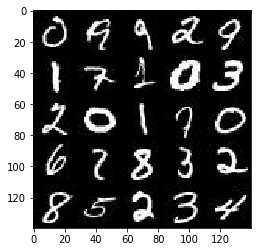

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

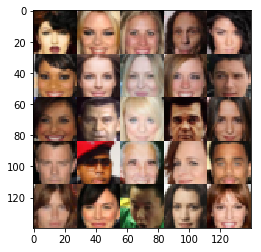

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate=tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    # The constant used in the leaky ReLU activation function.
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # The discriminator uses the DCGAN architecture. Batch normalization is
        # used on all layers except the first convolutional layer and the output layer.
        # Shape of images: 28x28x3 (CelebA) or 28x28x1 (MNIST)
        
        # First convolutional layer.
        # Resulting shape: 14x14x64
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)  # Leaky ReLU
        
        # Second convolutional layer.
        # Resulting shape: 7x7x128
        x2 = tf.layers.conv2d(x1, 128, (5,5), 2, 'same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # Third convolutional layer.
        # Note: According to the TensorFlow documentation, a ceiling operator
        # is applied to the output width and height when using SAME padding.
        # That's why the width and height of 7 are downscaled to 4.
        # See https://www.tensorflow.org/api_guides/python/nn#Convolution.
        # Resulting shape: 4x4x256
        x3 = tf.layers.conv2d(x2, 256, (5,5), 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(inputs=flat, units=1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # The constant used in the leaky ReLU activation function.
    alpha = 0.2
    
    # Only reuse variables if we're not training the network.
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Fully connected layer.
        # Resulting shape: 7x7x512
        x1 = tf.layers.dense(inputs=z, units=7*7*512, activation=None)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)  # Leaky ReLU
        
        # First convolutional layer.
        # Resulting shape: 14x14x256
        x2 = tf.layers.conv2d_transpose(inputs=x1, filters=256, kernel_size=(5, 5), strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
                
        # Second convolutional layer.
        # Resulting shape: 28x28x128
        x3 = tf.layers.conv2d_transpose(x2, 128, (5, 5), 2, 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer.
        # Resulting shape: 28x28x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, (5, 5), 1, 'same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Wether or not to use label smoothing.
    use_label_smoothing = True
    
    # The label smoothing factor used to help the discriminator generalize better.
    smooth = 0.1

    # The generator output.
    g_model = generator(input_z, out_channel_dim, is_train=True)

    # The discriminator output and logits when fed the real and fake images.
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the discriminator loss.
    # ---------------------------------
    # For real images, the labels are all ones (because they are the real images).
    if use_label_smoothing:
        d_labels_real = tf.ones_like(d_model_real) * (1 - smooth)
    else:
        d_labels_real = tf.ones_like(d_model_real)
    d_cross_entropy_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real)
    d_loss_real = tf.reduce_mean(d_cross_entropy_real)
    
    # For fake images, the labels are all zeros (because they are the fake images).
    d_lables_fake = tf.zeros_like(d_model_fake) * (1 - smooth)
    d_cross_entroy_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_lables_fake)
    d_loss_fake = tf.reduce_mean(d_cross_entroy_fake)
    
    # Calculate the total loss.
    d_loss = d_loss_real + d_loss_fake
    
    # Calculate the generator loss.
    # -----------------------------
    # Remember, the generator is trying to fool the discriminator into outputting
    # ones for fake images. That's why the labels are set to all ones for the fake output.
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and biases to update, separately for the discriminator and the generator.
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Run the optimizer on the respective discriminator and generator variables.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print("data_shape={}".format(data_shape))
    print("data_image_mode={}".format(data_image_mode))
    
    # saver = tf.train.Saver()
    
    # Build the model.
    # ----------------
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    # Train the model.
    # ----------------
    batch_i = 0
    losses = []
    n_images = 25
    show_losses_every = 10
    show_output_every = 50
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_i += 1
                
                # Rescale images from (-0.5, 0.5) to (-1, 1), because we're using the
                # tanh activation function in the generator which has a range of (-1, 1).
                batch_images = batch_images * 2

                # Sample random noise for the generator.
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run the optimizers on both the discriminator and the generator.
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                # Note_ We need to pass the values for the placeholders 'input_real'
                # and 'lr' here to satisfy TensorFlow. They aren't actually used.
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                # Print losses every 25 batches.
                if batch_i % show_losses_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Batch {}...".format(batch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    # Save losses to view after training.
                    losses.append((train_loss_d, train_loss_g))

                # Print generator output every 100 batches.
                if batch_i % show_output_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
            print("Batches per epoch: {}".format(batch_i))    
            
        show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
        # saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data_shape=(60000, 28, 28, 1)
data_image_mode=L
Epoch 1/2... Batch 10... Discriminator Loss: 0.3701... Generator Loss: 5.2601
Epoch 1/2... Batch 20... Discriminator Loss: 0.7254... Generator Loss: 6.1021
Epoch 1/2... Batch 30... Discriminator Loss: 0.4073... Generator Loss: 6.2442
Epoch 1/2... Batch 40... Discriminator Loss: 0.8090... Generator Loss: 2.1392
Epoch 1/2... Batch 50... Discriminator Loss: 0.4148... Generator Loss: 4.6908


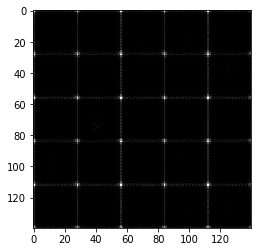

Epoch 1/2... Batch 60... Discriminator Loss: 0.4338... Generator Loss: 3.1963
Epoch 1/2... Batch 70... Discriminator Loss: 1.5346... Generator Loss: 2.4663
Epoch 1/2... Batch 80... Discriminator Loss: 1.0679... Generator Loss: 1.6618
Epoch 1/2... Batch 90... Discriminator Loss: 1.1282... Generator Loss: 0.9157
Epoch 1/2... Batch 100... Discriminator Loss: 1.1951... Generator Loss: 0.6905


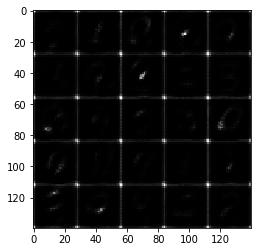

Epoch 1/2... Batch 110... Discriminator Loss: 0.8714... Generator Loss: 1.5321
Epoch 1/2... Batch 120... Discriminator Loss: 1.0837... Generator Loss: 1.0739
Epoch 1/2... Batch 130... Discriminator Loss: 1.1735... Generator Loss: 1.6822
Epoch 1/2... Batch 140... Discriminator Loss: 1.0943... Generator Loss: 1.3243
Epoch 1/2... Batch 150... Discriminator Loss: 1.2111... Generator Loss: 0.8393


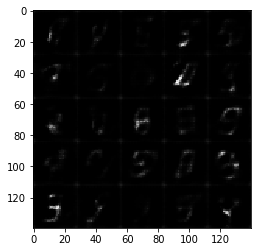

Epoch 1/2... Batch 160... Discriminator Loss: 1.3252... Generator Loss: 0.6823
Epoch 1/2... Batch 170... Discriminator Loss: 1.1034... Generator Loss: 1.6036
Epoch 1/2... Batch 180... Discriminator Loss: 1.5852... Generator Loss: 0.4576
Epoch 1/2... Batch 190... Discriminator Loss: 1.1211... Generator Loss: 1.4492
Epoch 1/2... Batch 200... Discriminator Loss: 1.0471... Generator Loss: 1.0679


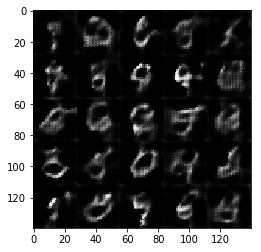

Epoch 1/2... Batch 210... Discriminator Loss: 1.1180... Generator Loss: 1.7680
Epoch 1/2... Batch 220... Discriminator Loss: 1.1868... Generator Loss: 0.8223
Epoch 1/2... Batch 230... Discriminator Loss: 1.2236... Generator Loss: 1.1184
Batches per epoch: 234
Epoch 2/2... Batch 240... Discriminator Loss: 1.1181... Generator Loss: 1.0298
Epoch 2/2... Batch 250... Discriminator Loss: 1.1177... Generator Loss: 1.1312


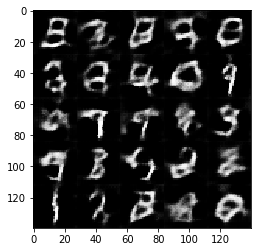

Epoch 2/2... Batch 260... Discriminator Loss: 1.4592... Generator Loss: 1.6883
Epoch 2/2... Batch 270... Discriminator Loss: 1.1385... Generator Loss: 0.9633
Epoch 2/2... Batch 280... Discriminator Loss: 1.2719... Generator Loss: 0.7260
Epoch 2/2... Batch 290... Discriminator Loss: 1.2346... Generator Loss: 1.4505
Epoch 2/2... Batch 300... Discriminator Loss: 1.1123... Generator Loss: 1.0176


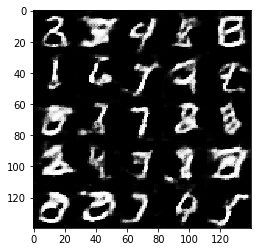

Epoch 2/2... Batch 310... Discriminator Loss: 1.3791... Generator Loss: 1.7489
Epoch 2/2... Batch 320... Discriminator Loss: 1.2304... Generator Loss: 0.7724
Epoch 2/2... Batch 330... Discriminator Loss: 1.1616... Generator Loss: 0.9231
Epoch 2/2... Batch 340... Discriminator Loss: 1.1758... Generator Loss: 0.8944
Epoch 2/2... Batch 350... Discriminator Loss: 1.1469... Generator Loss: 0.9536


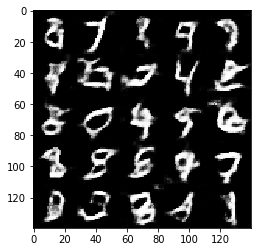

Epoch 2/2... Batch 360... Discriminator Loss: 1.2707... Generator Loss: 1.6080
Epoch 2/2... Batch 370... Discriminator Loss: 1.1466... Generator Loss: 0.8557
Epoch 2/2... Batch 380... Discriminator Loss: 1.3024... Generator Loss: 0.6340
Epoch 2/2... Batch 390... Discriminator Loss: 1.2111... Generator Loss: 0.7736
Epoch 2/2... Batch 400... Discriminator Loss: 1.1332... Generator Loss: 1.0134


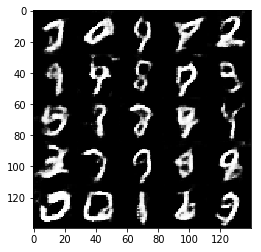

Epoch 2/2... Batch 410... Discriminator Loss: 1.2589... Generator Loss: 0.6614
Epoch 2/2... Batch 420... Discriminator Loss: 1.3009... Generator Loss: 0.6065
Epoch 2/2... Batch 430... Discriminator Loss: 1.1378... Generator Loss: 0.9462
Epoch 2/2... Batch 440... Discriminator Loss: 1.2623... Generator Loss: 1.5635
Epoch 2/2... Batch 450... Discriminator Loss: 1.0839... Generator Loss: 1.0261


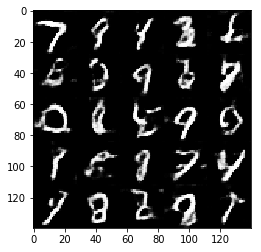

Epoch 2/2... Batch 460... Discriminator Loss: 1.1138... Generator Loss: 1.2328
Batches per epoch: 468


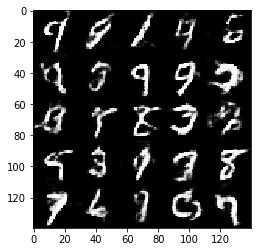

In [24]:
batch_size = 256
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses_mnist = train(epochs, batch_size, z_dim, learning_rate, beta1, 
                         mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

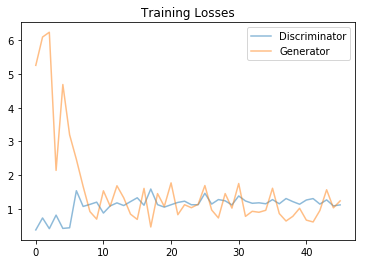

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt

losses_mnist = np.array(losses_mnist)
plt.plot(losses_mnist.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_mnist.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape=(202599, 28, 28, 3)
data_image_mode=RGB
Epoch 1/1... Batch 10... Discriminator Loss: 0.4582... Generator Loss: 4.2504
Epoch 1/1... Batch 20... Discriminator Loss: 0.3866... Generator Loss: 5.5551
Epoch 1/1... Batch 30... Discriminator Loss: 0.4469... Generator Loss: 2.9511
Epoch 1/1... Batch 40... Discriminator Loss: 1.9562... Generator Loss: 1.3563
Epoch 1/1... Batch 50... Discriminator Loss: 1.8239... Generator Loss: 9.5992


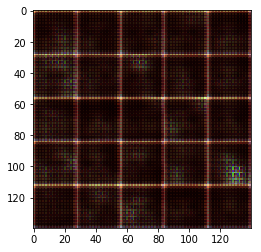

Epoch 1/1... Batch 60... Discriminator Loss: 0.5118... Generator Loss: 3.9303
Epoch 1/1... Batch 70... Discriminator Loss: 0.7853... Generator Loss: 1.3685
Epoch 1/1... Batch 80... Discriminator Loss: 0.5603... Generator Loss: 2.2534
Epoch 1/1... Batch 90... Discriminator Loss: 0.5082... Generator Loss: 2.8451
Epoch 1/1... Batch 100... Discriminator Loss: 0.8502... Generator Loss: 1.2140


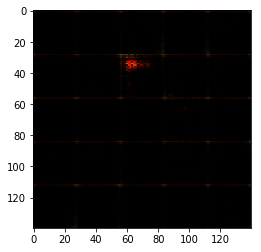

Epoch 1/1... Batch 110... Discriminator Loss: 0.3946... Generator Loss: 4.4050
Epoch 1/1... Batch 120... Discriminator Loss: 0.4575... Generator Loss: 2.6452
Epoch 1/1... Batch 130... Discriminator Loss: 1.9131... Generator Loss: 0.3941
Epoch 1/1... Batch 140... Discriminator Loss: 0.5780... Generator Loss: 2.3591
Epoch 1/1... Batch 150... Discriminator Loss: 1.9920... Generator Loss: 0.3002


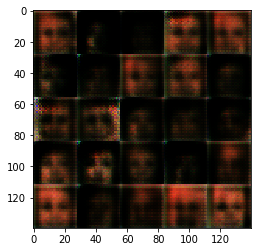

Epoch 1/1... Batch 160... Discriminator Loss: 1.1589... Generator Loss: 1.3086
Epoch 1/1... Batch 170... Discriminator Loss: 1.3383... Generator Loss: 0.5410
Epoch 1/1... Batch 180... Discriminator Loss: 1.0686... Generator Loss: 1.3299
Epoch 1/1... Batch 190... Discriminator Loss: 1.3312... Generator Loss: 0.6644
Epoch 1/1... Batch 200... Discriminator Loss: 2.2042... Generator Loss: 4.4254


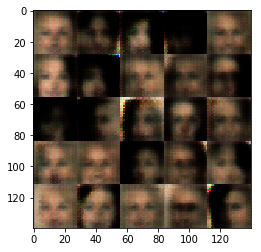

Epoch 1/1... Batch 210... Discriminator Loss: 1.5182... Generator Loss: 0.9572
Epoch 1/1... Batch 220... Discriminator Loss: 1.5487... Generator Loss: 2.8841
Epoch 1/1... Batch 230... Discriminator Loss: 0.7535... Generator Loss: 1.6854
Epoch 1/1... Batch 240... Discriminator Loss: 1.2518... Generator Loss: 0.6647
Epoch 1/1... Batch 250... Discriminator Loss: 1.2292... Generator Loss: 0.6556


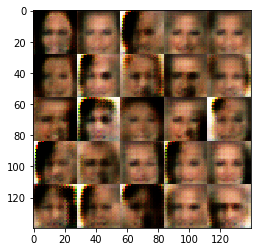

Epoch 1/1... Batch 260... Discriminator Loss: 0.9291... Generator Loss: 1.6082
Epoch 1/1... Batch 270... Discriminator Loss: 1.0638... Generator Loss: 0.9029
Epoch 1/1... Batch 280... Discriminator Loss: 1.1299... Generator Loss: 1.5570
Epoch 1/1... Batch 290... Discriminator Loss: 1.5394... Generator Loss: 0.4885
Epoch 1/1... Batch 300... Discriminator Loss: 1.3747... Generator Loss: 0.5959


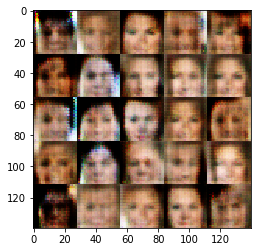

Epoch 1/1... Batch 310... Discriminator Loss: 1.0663... Generator Loss: 1.4400
Epoch 1/1... Batch 320... Discriminator Loss: 1.1060... Generator Loss: 0.9684
Epoch 1/1... Batch 330... Discriminator Loss: 1.6073... Generator Loss: 0.3959
Epoch 1/1... Batch 340... Discriminator Loss: 1.1258... Generator Loss: 1.2911
Epoch 1/1... Batch 350... Discriminator Loss: 0.9081... Generator Loss: 1.4294


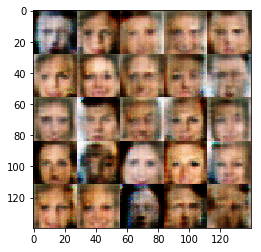

Epoch 1/1... Batch 360... Discriminator Loss: 1.2438... Generator Loss: 0.8877
Epoch 1/1... Batch 370... Discriminator Loss: 1.3035... Generator Loss: 1.7084
Epoch 1/1... Batch 380... Discriminator Loss: 1.1222... Generator Loss: 0.8286
Epoch 1/1... Batch 390... Discriminator Loss: 1.0187... Generator Loss: 1.5917
Epoch 1/1... Batch 400... Discriminator Loss: 1.4242... Generator Loss: 1.8678


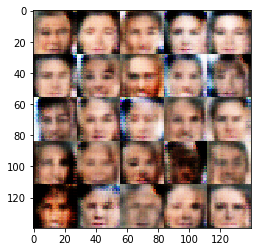

Epoch 1/1... Batch 410... Discriminator Loss: 1.2015... Generator Loss: 0.7387
Epoch 1/1... Batch 420... Discriminator Loss: 1.0309... Generator Loss: 0.9263
Epoch 1/1... Batch 430... Discriminator Loss: 1.5145... Generator Loss: 0.6998
Epoch 1/1... Batch 440... Discriminator Loss: 1.5144... Generator Loss: 0.7842
Epoch 1/1... Batch 450... Discriminator Loss: 1.5977... Generator Loss: 0.4199


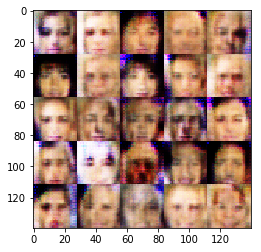

Epoch 1/1... Batch 460... Discriminator Loss: 1.3007... Generator Loss: 0.8468
Epoch 1/1... Batch 470... Discriminator Loss: 1.1727... Generator Loss: 1.4942
Epoch 1/1... Batch 480... Discriminator Loss: 0.7498... Generator Loss: 1.5079
Epoch 1/1... Batch 490... Discriminator Loss: 1.2128... Generator Loss: 0.9453
Epoch 1/1... Batch 500... Discriminator Loss: 1.0108... Generator Loss: 1.0496


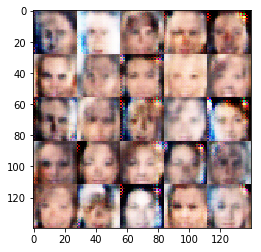

Epoch 1/1... Batch 510... Discriminator Loss: 1.4082... Generator Loss: 0.5073
Epoch 1/1... Batch 520... Discriminator Loss: 1.2580... Generator Loss: 1.3123
Epoch 1/1... Batch 530... Discriminator Loss: 1.2922... Generator Loss: 1.5837
Epoch 1/1... Batch 540... Discriminator Loss: 0.8131... Generator Loss: 1.8859
Epoch 1/1... Batch 550... Discriminator Loss: 0.9753... Generator Loss: 1.1128


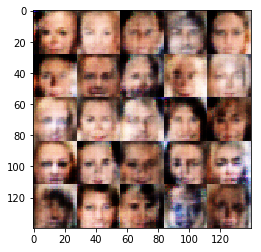

Epoch 1/1... Batch 560... Discriminator Loss: 1.0502... Generator Loss: 1.2258
Epoch 1/1... Batch 570... Discriminator Loss: 1.1105... Generator Loss: 1.1354
Epoch 1/1... Batch 580... Discriminator Loss: 1.4806... Generator Loss: 0.4946
Epoch 1/1... Batch 590... Discriminator Loss: 1.2928... Generator Loss: 1.2464
Epoch 1/1... Batch 600... Discriminator Loss: 1.2391... Generator Loss: 0.6193


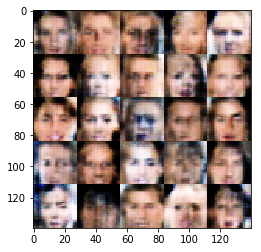

Epoch 1/1... Batch 610... Discriminator Loss: 3.1267... Generator Loss: 2.8359
Epoch 1/1... Batch 620... Discriminator Loss: 1.1543... Generator Loss: 1.5594
Epoch 1/1... Batch 630... Discriminator Loss: 1.6848... Generator Loss: 0.3447
Epoch 1/1... Batch 640... Discriminator Loss: 1.1060... Generator Loss: 0.9341
Epoch 1/1... Batch 650... Discriminator Loss: 1.6376... Generator Loss: 0.3614


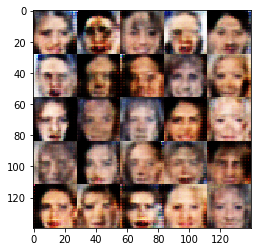

Epoch 1/1... Batch 660... Discriminator Loss: 1.1132... Generator Loss: 0.9536
Epoch 1/1... Batch 670... Discriminator Loss: 1.2561... Generator Loss: 0.8237
Epoch 1/1... Batch 680... Discriminator Loss: 0.9744... Generator Loss: 0.8911
Epoch 1/1... Batch 690... Discriminator Loss: 0.6687... Generator Loss: 2.9720
Epoch 1/1... Batch 700... Discriminator Loss: 1.0121... Generator Loss: 1.2062


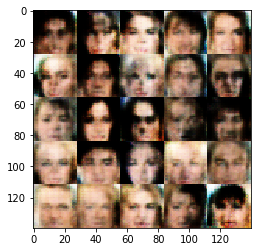

Epoch 1/1... Batch 710... Discriminator Loss: 1.4393... Generator Loss: 0.9478
Epoch 1/1... Batch 720... Discriminator Loss: 1.1797... Generator Loss: 0.8982
Epoch 1/1... Batch 730... Discriminator Loss: 1.0138... Generator Loss: 1.0244
Epoch 1/1... Batch 740... Discriminator Loss: 1.3113... Generator Loss: 0.6286
Epoch 1/1... Batch 750... Discriminator Loss: 1.2570... Generator Loss: 0.6752


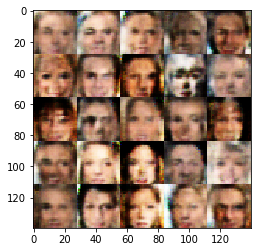

Epoch 1/1... Batch 760... Discriminator Loss: 1.0379... Generator Loss: 1.2067
Epoch 1/1... Batch 770... Discriminator Loss: 1.5949... Generator Loss: 1.8788
Epoch 1/1... Batch 780... Discriminator Loss: 1.2633... Generator Loss: 0.7247
Epoch 1/1... Batch 790... Discriminator Loss: 1.0259... Generator Loss: 1.5065
Epoch 1/1... Batch 800... Discriminator Loss: 1.2695... Generator Loss: 0.8278


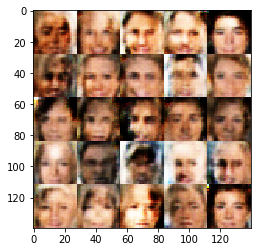

Epoch 1/1... Batch 810... Discriminator Loss: 1.0646... Generator Loss: 1.2988
Epoch 1/1... Batch 820... Discriminator Loss: 1.1515... Generator Loss: 1.5503
Epoch 1/1... Batch 830... Discriminator Loss: 2.6615... Generator Loss: 2.8924
Epoch 1/1... Batch 840... Discriminator Loss: 1.1325... Generator Loss: 1.2086
Epoch 1/1... Batch 850... Discriminator Loss: 1.1752... Generator Loss: 0.9913


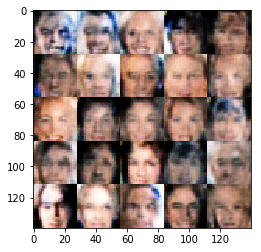

Epoch 1/1... Batch 860... Discriminator Loss: 1.2656... Generator Loss: 0.6170
Epoch 1/1... Batch 870... Discriminator Loss: 1.9334... Generator Loss: 2.2603
Epoch 1/1... Batch 880... Discriminator Loss: 1.1327... Generator Loss: 1.0270
Epoch 1/1... Batch 890... Discriminator Loss: 1.0176... Generator Loss: 1.0871
Epoch 1/1... Batch 900... Discriminator Loss: 1.1915... Generator Loss: 0.9857


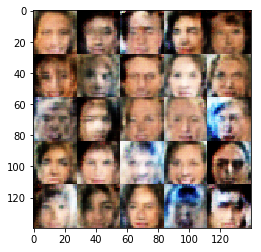

Epoch 1/1... Batch 910... Discriminator Loss: 1.2953... Generator Loss: 1.0625
Epoch 1/1... Batch 920... Discriminator Loss: 1.2840... Generator Loss: 1.2865
Epoch 1/1... Batch 930... Discriminator Loss: 1.2068... Generator Loss: 0.8306
Epoch 1/1... Batch 940... Discriminator Loss: 1.0487... Generator Loss: 1.0823
Epoch 1/1... Batch 950... Discriminator Loss: 0.8623... Generator Loss: 1.1599


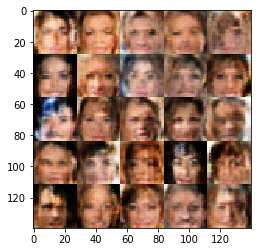

Epoch 1/1... Batch 960... Discriminator Loss: 1.3069... Generator Loss: 1.1759
Epoch 1/1... Batch 970... Discriminator Loss: 1.3703... Generator Loss: 0.7261
Epoch 1/1... Batch 980... Discriminator Loss: 1.2394... Generator Loss: 0.5774
Epoch 1/1... Batch 990... Discriminator Loss: 1.2577... Generator Loss: 0.8073
Epoch 1/1... Batch 1000... Discriminator Loss: 1.1318... Generator Loss: 1.2433


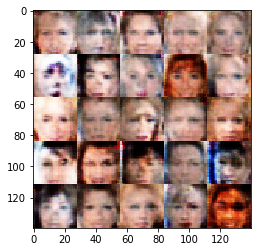

Epoch 1/1... Batch 1010... Discriminator Loss: 1.1759... Generator Loss: 1.6736
Epoch 1/1... Batch 1020... Discriminator Loss: 1.1680... Generator Loss: 2.0147
Epoch 1/1... Batch 1030... Discriminator Loss: 1.2192... Generator Loss: 0.9056
Epoch 1/1... Batch 1040... Discriminator Loss: 1.6965... Generator Loss: 1.3712
Epoch 1/1... Batch 1050... Discriminator Loss: 1.3609... Generator Loss: 1.1224


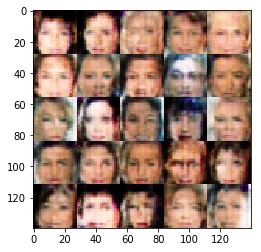

Epoch 1/1... Batch 1060... Discriminator Loss: 1.2292... Generator Loss: 1.2556
Epoch 1/1... Batch 1070... Discriminator Loss: 1.2386... Generator Loss: 1.2458
Epoch 1/1... Batch 1080... Discriminator Loss: 1.3828... Generator Loss: 0.7534
Epoch 1/1... Batch 1090... Discriminator Loss: 1.4203... Generator Loss: 0.7754
Epoch 1/1... Batch 1100... Discriminator Loss: 1.3446... Generator Loss: 0.5196


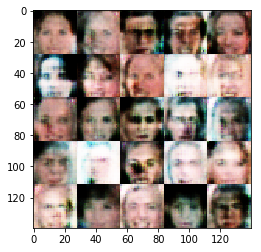

Epoch 1/1... Batch 1110... Discriminator Loss: 0.8521... Generator Loss: 1.3523
Epoch 1/1... Batch 1120... Discriminator Loss: 1.0701... Generator Loss: 0.7876
Epoch 1/1... Batch 1130... Discriminator Loss: 1.1847... Generator Loss: 0.8921
Epoch 1/1... Batch 1140... Discriminator Loss: 1.3138... Generator Loss: 1.1489
Epoch 1/1... Batch 1150... Discriminator Loss: 2.5465... Generator Loss: 3.2086


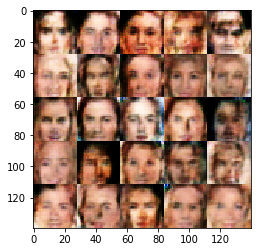

Epoch 1/1... Batch 1160... Discriminator Loss: 1.2353... Generator Loss: 0.8813
Epoch 1/1... Batch 1170... Discriminator Loss: 1.2774... Generator Loss: 0.7799
Epoch 1/1... Batch 1180... Discriminator Loss: 1.1278... Generator Loss: 0.7748
Epoch 1/1... Batch 1190... Discriminator Loss: 1.1536... Generator Loss: 1.2352
Epoch 1/1... Batch 1200... Discriminator Loss: 1.4182... Generator Loss: 1.3957


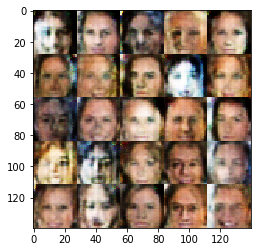

Epoch 1/1... Batch 1210... Discriminator Loss: 1.4231... Generator Loss: 0.4836
Epoch 1/1... Batch 1220... Discriminator Loss: 1.1270... Generator Loss: 1.2181
Epoch 1/1... Batch 1230... Discriminator Loss: 1.7986... Generator Loss: 0.3020
Epoch 1/1... Batch 1240... Discriminator Loss: 1.7258... Generator Loss: 1.8893
Epoch 1/1... Batch 1250... Discriminator Loss: 0.9522... Generator Loss: 1.2043


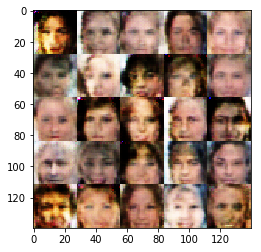

Epoch 1/1... Batch 1260... Discriminator Loss: 1.1520... Generator Loss: 2.1949
Epoch 1/1... Batch 1270... Discriminator Loss: 1.3056... Generator Loss: 0.7639
Epoch 1/1... Batch 1280... Discriminator Loss: 1.5702... Generator Loss: 0.5308
Epoch 1/1... Batch 1290... Discriminator Loss: 1.2871... Generator Loss: 1.2857
Epoch 1/1... Batch 1300... Discriminator Loss: 1.0345... Generator Loss: 1.0382


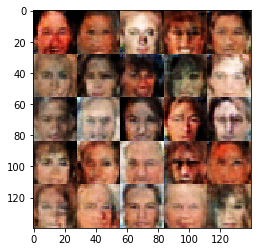

Epoch 1/1... Batch 1310... Discriminator Loss: 1.4217... Generator Loss: 0.6170
Epoch 1/1... Batch 1320... Discriminator Loss: 1.3418... Generator Loss: 0.7597
Epoch 1/1... Batch 1330... Discriminator Loss: 1.1587... Generator Loss: 1.2564
Epoch 1/1... Batch 1340... Discriminator Loss: 1.5813... Generator Loss: 0.3870
Epoch 1/1... Batch 1350... Discriminator Loss: 0.9892... Generator Loss: 1.1610


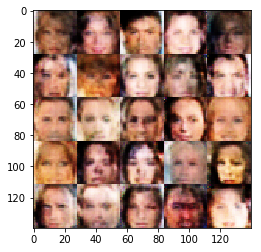

Epoch 1/1... Batch 1360... Discriminator Loss: 1.2559... Generator Loss: 0.7655
Epoch 1/1... Batch 1370... Discriminator Loss: 1.5727... Generator Loss: 1.4715
Epoch 1/1... Batch 1380... Discriminator Loss: 1.4407... Generator Loss: 0.9147
Epoch 1/1... Batch 1390... Discriminator Loss: 1.2141... Generator Loss: 0.8619
Epoch 1/1... Batch 1400... Discriminator Loss: 2.7022... Generator Loss: 2.9437


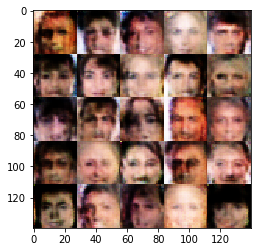

Epoch 1/1... Batch 1410... Discriminator Loss: 1.1550... Generator Loss: 0.9605
Epoch 1/1... Batch 1420... Discriminator Loss: 1.3974... Generator Loss: 0.6172
Epoch 1/1... Batch 1430... Discriminator Loss: 1.1094... Generator Loss: 1.4899
Epoch 1/1... Batch 1440... Discriminator Loss: 1.0861... Generator Loss: 1.2502
Epoch 1/1... Batch 1450... Discriminator Loss: 0.9760... Generator Loss: 1.0348


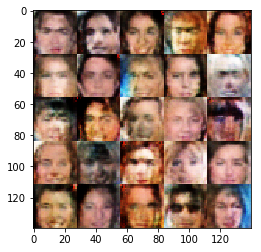

Epoch 1/1... Batch 1460... Discriminator Loss: 1.8946... Generator Loss: 2.4914
Epoch 1/1... Batch 1470... Discriminator Loss: 1.3792... Generator Loss: 1.8027
Epoch 1/1... Batch 1480... Discriminator Loss: 1.0638... Generator Loss: 1.2190
Epoch 1/1... Batch 1490... Discriminator Loss: 1.0760... Generator Loss: 0.9049
Epoch 1/1... Batch 1500... Discriminator Loss: 1.6194... Generator Loss: 1.5866


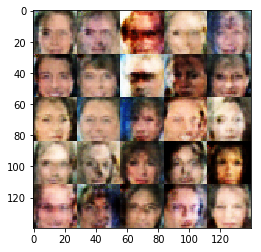

Epoch 1/1... Batch 1510... Discriminator Loss: 1.3525... Generator Loss: 1.1137
Epoch 1/1... Batch 1520... Discriminator Loss: 0.8649... Generator Loss: 1.3094
Epoch 1/1... Batch 1530... Discriminator Loss: 0.9939... Generator Loss: 1.5049
Epoch 1/1... Batch 1540... Discriminator Loss: 1.3055... Generator Loss: 0.6796
Epoch 1/1... Batch 1550... Discriminator Loss: 1.3386... Generator Loss: 1.0188


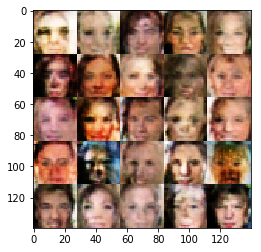

Epoch 1/1... Batch 1560... Discriminator Loss: 0.7165... Generator Loss: 1.4517
Epoch 1/1... Batch 1570... Discriminator Loss: 0.5392... Generator Loss: 1.9473
Epoch 1/1... Batch 1580... Discriminator Loss: 0.9871... Generator Loss: 1.1805
Batches per epoch: 1582


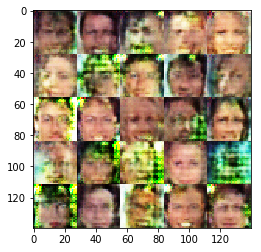

In [26]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses_celeba = train(epochs, batch_size, z_dim, learning_rate, beta1,
                          celeba_dataset.get_batches, celeba_dataset.shape, celeba_dataset.image_mode)

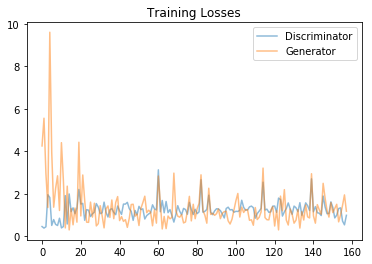

In [27]:
losses_celeba = np.array(losses_celeba)
plt.plot(losses_celeba.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_celeba.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.